In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from astropy.io import fits
import scipy.sparse
import scipy.linalg
import time

from astropy.io import fits # [added to write outputs. C.M.H.]

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
eV_to_erg = 1.6022e-12
parsec_to_cm = 3.085677581e18 # cm per parsec

kB = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G
e = 2.718281828459 # base of natural log
e_char = 1.602e-19 * c / 10 # electron charge in esu

z = 2
z2 = (1 + z) / 3
T_CMB *= 1+z # scale to CMB temperature at that redshift <-- C.M.H.

In [2]:
with open('rate_z2_10Mpc_new.pkl', 'rb') as f:
    rata_arr = pkl.load(f)
    
rate_arr = np.array(rata_arr)
rate_arr = rate_arr.reshape(400,400) # [i][j]: gamma[i] theta[j], rate_arr[-1] = nan
rate_trans = np.transpose(rate_arr) # [i][j]: theta[i] gamma[j], rate_trans[i][-1] = nan
rate_trans[:,-1]=0. # remove nan <-- C.M.H.
#fits.PrimaryHDU(rate_trans).writeto('rate_trans.fits', overwrite=True)

gamma_e_arr = np.logspace(8, 14, 400) * eV_to_erg / m_e / c**2 # lab-frame Lorentz factor of the electron produced
theta_e_arr = np.logspace(-8,0, 400)

### read theta_rms directly

In [3]:
prefix_sums = np.load("prefix_sums_new.npy")
print(prefix_sums[0], prefix_sums[-1])

9.9066004556493e-11 7.154739952002411e-20


In [4]:
def calculate_solid_angles(theta):
    # theta_half[i] = theta[i-1/2]
    theta_half = (theta[1:] + theta[:-1]) / 2
    theta_half = np.concatenate([[theta[0]/2], theta_half, [3*theta[-1]/2 - theta[-2]/2]])

    Omega = 2 * np.pi * (theta_half[2:]**2 - theta_half[:-2]**2) / 2  # solid angles of annulus
    Omega = np.concatenate([Omega, [2 * np.pi * (theta[-1]**2 - theta_half[-2]**2)]])  # add the last circle

    return Omega, theta_half

In [5]:
Omega, theta_half = calculate_solid_angles(theta_e_arr)

In [6]:
M = np.zeros((400, 400))

for i in range(400):
    for j in range(400):
        if j == i + 1:
            M[i, j] = -2 * np.pi / Omega[i] * theta_half[i+1] / (theta_e_arr[i+1] - theta_e_arr[i])
        if j == i - 1:
            M[i, j] = -2 * np.pi / Omega[i] * theta_half[i] / (theta_e_arr[i] - theta_e_arr[i-1])
for i in range(1,399):
    M[i, i] = 2 * np.pi / Omega[i] * (theta_half[i+1] / (theta_e_arr[i+1] - theta_e_arr[i]) + theta_half[i] / (theta_e_arr[i] - theta_e_arr[i-1]))

M[0,0] = -M[1,0]*Omega[1]/Omega[0]
M[-1,-1] = -M[-2,-1]*Omega[-2]/Omega[-1]

In [7]:
P = np.diag(np.sqrt(1/Omega))
L = np.linalg.inv(P)@M@P
eigenvalues_L, eigenvectors_L = np.linalg.eigh(L)
R_L = eigenvectors_L.copy()
lambda_l = eigenvalues_L.copy()

V = eigenvectors_L.copy()
V_inv = np.linalg.inv(V)

### new element of coulomb

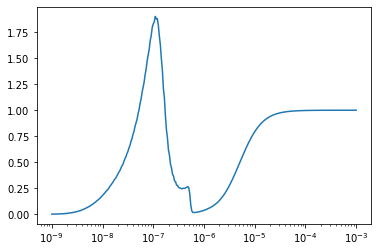

In [8]:
F_NP = np.loadtxt('fnpk_z2_new.dat')
k_prep = F_NP[:, 0]
fnpk = F_NP[:, 1]
plt.plot(k_prep, fnpk)
plt.xscale('log')
plt.show()

In [9]:
dk = np.array([F_NP[:, 0][i] - F_NP[:, 0][i-1] for i in range(1, 301)])
dk = np.insert(dk, 0, 0)

k_cut = F_NP[:, 0][-1] # suppose, as long as k_cut at fnpk ~1 region, doesn't matter of value choosen
print(k_cut)

0.001


In [10]:
omega_b = omega_b_0 * (1 + z)**3
mean_n_b = 3 * omega_b * H_0 * H_0 / (8 * np.pi * G * m_p) # mean number density of baryons at the redshift
n_b = mean_n_b # for mean density
    
n_H = n_b * (1 - Y_He) # nuclei in hydrogen
n_He = n_H * f_He # nuclei in helium, assume He is all 4He

n_e = n_H + 2 * n_He # for fully ionized

In [11]:
nsp = 3 # number of species
mass_sp = np.array([m_e, m_p, 4*m_p]) # masses
nth_sp = np.array([n_e,n_H,n_He]) # number densities
Z_sp = np.array([-1.,1.,2.]) # charges

Z_proj = 1 # charge number of the beam

int_FNP = np.trapz(fnpk / k_prep, x=k_prep) # integral part of eq 37

def T_vectorized(gamma, l): # eq 37
    beta = np.sqrt(1 - 1/gamma**2)
    v_proj = beta * c # velocity of the beam
    p_proj = gamma * m_e * v_proj
    co = 2 * np.pi * l**2 * Z_proj**2 * e_char**4 / (p_proj**2 * v_proj)
    
    ## vectorize
    gamma_E = np.euler_gamma # Euler's constant
    
    B = 1 - gamma_E - np.log(h/2/np.pi * k_cut * l / p_proj) # the Coulomb‐log piece
    W = np.sum(Z_sp**2 * nth_sp) # species weight
    
    return co * W * (int_FNP + B)

In [12]:
Gamma_IC0 = 1.1e-18 * z2**4

def T_ij(l, i, j):
    #print('l', l)
    gamma_ij = gamma_e_arr[i:j+1]
    Tl = T_vectorized(gamma_ij, l)
    integrand = Tl / (Gamma_IC0 * gamma_ij**2)
    #print('Tl', Tl)
    #print('integrand', integrand)
    I = np.trapz(integrand, x=gamma_ij)
    return -I

In [13]:
def get_nij(i, j, t, M_expm): # nij = dN / (dV dgammae_j dOmegae_i)
    Gamma_IC0 = 1.1e-18 * z2**4
    gamma_max_inv = 1. / gamma_e_arr[j] - Gamma_IC0 * t
    #print(f'i={i}, j={j}, gamma_max_inv={gamma_max_inv}')
    if gamma_max_inv>1e-99:
        gamma_max = 1./gamma_max_inv
    else:
        gamma_max = 1e99
        
    nij = 0
    
    for jp in range(j, 399):
        if gamma_e_arr[jp] <= gamma_max:
            # THIS IS A COMMENT: rate_trans_smoothed = M_expm @ rate_trans
            # Then, rate_trans_smoothed[i][jp] is the dot product of M_expm[jp][i] and rate_trans[:, jp]
            rate_trans_smoothed_ijp = np.dot(M_expm[jp, i, :], rate_trans[:, jp])
                
            sum_ij = (gamma_e_arr[jp] - gamma_e_arr[jp-1]) * rate_trans_smoothed_ijp
            
            if gamma_e_arr[jp+1] > gamma_max:
                fraction = (gamma_max - gamma_e_arr[jp]) / (gamma_e_arr[jp+1] - gamma_e_arr[jp])
                #print(f'sum_ij={sum_ij}, fraction={fraction}')
                sum_ij = sum_ij * fraction
            nij += sum_ij
    nij = nij / (Gamma_IC0 * gamma_e_arr[j]**2)
#     if nij > 1e-18:
#         print(f'sum_ij={sum_ij}')
    return nij

In [14]:
#t_arr = [1e8, 5e8, 1e9, 5e9, 1e10, 5e10, 1e11, 5e11, 1e12, 5e12, 1e13]
t_arr = [1e8, 1e9, 1e10, 1e11, 1e12, 1e13] # To save time, I cut it short
#t_arr = [1e9]
t_num = len(t_arr)

In [15]:
Omega_x = np.logspace(-8,0, 400).reshape(400, 1)

In [16]:
A = np.diag(eigenvalues_L) # sqrt(A[i][i])
l = np.array([np.sqrt(A[i][i]) for i in range(len(A))])
#print(l)
l = np.nan_to_num(l, nan=1e-99)
print(l)

[1.00000000e-99 1.00000000e-99 1.00000000e-99 2.61990748e+00
 6.13877552e+00 9.38494161e+00 1.25299003e+01 1.55841304e+01
 1.85373811e+01 2.13723695e+01 2.40659680e+01 2.44389448e+01
 2.60322776e+01 2.65837261e+01 2.88526365e+01 3.06860719e+01
 3.22259533e+01 3.29502262e+01 3.41013196e+01 3.62493818e+01
 3.85989251e+01 4.11682189e+01 4.35147395e+01 4.39925454e+01
 4.71182337e+01 4.74919549e+01 5.06073721e+01 5.45469451e+01
 5.50028208e+01 5.58945689e+01 5.90665533e+01 6.36673628e+01
 6.43775906e+01 7.08796735e+01 7.27976301e+01 7.69186368e+01
 7.83304970e+01 7.95852677e+01 8.62874714e+01 9.29032708e+01
 9.80059497e+01 9.97149591e+01 1.07862769e+02 1.13349862e+02
 1.19005245e+02 1.19859886e+02 1.29789392e+02 1.30610792e+02
 1.36460418e+02 1.40676900e+02 1.47527236e+02 1.54497637e+02
 1.62190848e+02 1.69534615e+02 1.76083821e+02 1.85562671e+02
 1.95523753e+02 2.14242282e+02 2.23620079e+02 2.24320573e+02
 2.34821028e+02 2.45967864e+02 2.69872500e+02 2.70461462e+02
 2.82785853e+02 3.051541

/var/folders/k2/qxng019s7y17hp_kgkzy9b180000gn/T/ipykernel_27976/3334361187.py:2: RuntimeWarning: invalid value encountered in sqrt
  l = np.array([np.sqrt(A[i][i]) for i in range(len(A))])


In [31]:
eigenvectors_L[:,0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [32]:
eigenvectors_L[:,1]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [33]:
eigenvectors_L[:,2]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [17]:
print(T_ij(l[3], 0, 1))
print(T_ij(l[3], 0, 399))
print(T_ij(l[3], 398, 399))
print(T_ij(l[-1], 0, 1))
print(T_ij(l[-1], 0, 399))
print(T_ij(l[-1], 398, 399))

-2.307981627492513e-07
-2.35602250046736e-06
-3.361566200092277e-25
-118311964986.41042
-1215384529150.795
-2.0874523375139904e-07


### Calculating nij

In [18]:
nij = np.zeros((t_num, 400, 400))
time_start = time.time()
for k in range(t_num):
    print(f'time {k} {t_arr[k]:.1e}', end = ' ')
    
    for j in range(1, 400):
        print(f'j = {j}, time = {(time.time()-time_start)/60}')
        M_new = np.zeros((400, 400, 400))
        for jp in range(j, 399):
            theta_rms = np.sqrt(prefix_sums[j] - prefix_sums[jp+1]) # from jp to j
            #print('theta_rms', theta_rms)
            #M_expm = scipy.linalg.expm(-theta_rms**2/4 * M)
            M_expm = P@R_L@np.diag(np.exp(-theta_rms**2/4*lambda_l))@R_L.T@np.linalg.inv(P)
            #print('M_expm', M_expm)
            
            ### new element for columb scattering
            new_EV = np.zeros((len(l)))
            for x in range(len(l)):
                new_EV[x] = np.exp(T_ij(l[x], j, jp)) # from jp to j, eq 39 exp part

            new_D = np.diag(new_EV)

            columb = np.dot(np.dot(V, new_D), V_inv)

            
            M_new[jp] = M_expm @ columb

            
            if np.isnan(M_new[jp,:,:].any()): print('test', j, jp, np.isnan(M_new[jp,:,:].any()))

        for i in range(400):
            nij[k][i][j-1] = get_nij(i, j, t_arr[k], M_new)
    print('t = ', (time.time() - time_start) / 60)

time 0 1.0e+08 j = 1, time = 1.085201899210612e-05
j = 2, time = 0.3111627817153931
j = 3, time = 0.5553207993507385
j = 4, time = 0.8099718689918518
j = 5, time = 1.0810720523198445
j = 6, time = 1.532487686475118
j = 7, time = 2.126426021258036
j = 8, time = 2.692692017555237
j = 9, time = 3.0266557335853577
j = 10, time = 3.298736369609833
j = 11, time = 3.5511261026064553
j = 12, time = 3.795473619302114
j = 13, time = 4.060650352636973
j = 14, time = 4.306428567568461
j = 15, time = 4.549435834089915
j = 16, time = 4.782540635267893
j = 17, time = 5.077952035268148
j = 18, time = 5.3225419839223225
j = 19, time = 5.569110532601674
j = 20, time = 5.82069700161616
j = 21, time = 6.404065767923991
j = 22, time = 6.665894035498301
j = 23, time = 6.949189964930216
j = 24, time = 7.2025861342748
j = 25, time = 7.439392817020416
j = 26, time = 7.6875075697898865
j = 27, time = 7.984527150789897
j = 28, time = 8.23737156788508
j = 29, time = 8.459923569361369
j = 30, time = 8.687977119286

In [19]:
np.save('nij_final.npy', nij)
print(nij)

[[[4.85113120e-32 5.34403259e-32 5.89377457e-32 ... 7.01447794e-31
   0.00000000e+00 0.00000000e+00]
  [4.85113120e-32 5.34403259e-32 5.89377457e-32 ... 5.87949540e-31
   0.00000000e+00 0.00000000e+00]
  [4.85113120e-32 5.34403259e-32 5.89377457e-32 ... 4.91812938e-31
   0.00000000e+00 0.00000000e+00]
  ...
  [4.28306107e-46 3.81744436e-46 3.40168732e-46 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [3.15561425e-46 2.81253718e-46 2.50739277e-46 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [2.32646715e-46 2.07363002e-46 1.84896309e-46 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[4.85113215e-31 5.34403368e-31 5.89377582e-31 ... 1.16381674e-30
   0.00000000e+00 0.00000000e+00]
  [4.85113215e-31 5.34403368e-31 5.89377582e-31 ... 9.75504556e-31
   0.00000000e+00 0.00000000e+00]
  [4.85113215e-31 5.34403368e-31 5.89377582e-31 ... 8.15998192e-31
   0.00000000e+00 0.00000000e+00]
  ...
  [4.28306191e-45 3.81744514e-45 3.40168804e-45 ... 0.00000000e+00
   0.00000

In [20]:
def get_ni(i, nij): # integrate gamma_e (1/gamma_e) nij
    ni = 0
    for j in range(1, 400):
        sum_i = (gamma_e_arr[j] - gamma_e_arr[j-1]) / gamma_e_arr[j] * nij[i][j]
        ni += sum_i
    return ni

In [21]:
ni = np.zeros((t_num, 400)) # about theta
for k in range(t_num):
    for i in range(400):
        ni[k][i] = get_ni(i, nij[k])
        
np.save('ni_final.npy', nij)
print(ni)

[[2.15097180e-20 2.13680718e-20 2.12021980e-20 ... 1.19609950e-46
  8.82679880e-47 6.51692328e-47]
 [2.17852225e-19 2.16416606e-19 2.14731963e-19 ... 1.19609984e-45
  8.82680136e-46 6.51692517e-46]
 [2.30590141e-18 2.29240352e-18 2.27612890e-18 ... 1.19610334e-44
  8.82682714e-45 6.51694420e-45]
 [3.48126625e-17 3.46690309e-17 3.44926149e-17 ... 1.19613825e-43
  8.82708487e-44 6.51713455e-44]
 [9.02543246e-16 9.01197508e-16 8.99536183e-16 ... 1.19648751e-42
  8.82966325e-43 6.51903875e-43]
 [2.34215617e-14 2.34156618e-14 2.34083707e-14 ... 1.19999024e-41
  8.85552161e-42 6.53813587e-42]]


In [22]:
mc = np.zeros((400, t_num+1))
mc[:,0] = theta_e_arr
mc[:,1:] = ni.T
#np.savetxt('ni.dat', mc)

In [23]:
deriv_array = np.zeros((400,t_num))
for j in range(399):
    for jp in range(j,399):
        if j==jp:
            tr = 0.
        else:
            tr = np.arccosh(theta_e_arr[jp]/theta_e_arr[j])
        deriv_array[j,:] += 2 * theta_e_arr[j] * (ni[:,jp+1]-ni[:,jp])/(theta_e_arr[jp+1]-theta_e_arr[jp])\
          * (np.arccosh(theta_e_arr[jp+1]/theta_e_arr[j]) - tr)
mc2 = np.zeros((400, t_num+1))
mc2[:,0] = theta_e_arr
mc2[:,1:] = deriv_array
#np.savetxt('deriv_array_new.dat', mc2)

In [24]:
print(-mc2[:,1:])

[[ 1.80406558e-20  1.83242802e-19  1.92846644e-18  2.80260214e-17
   4.96805015e-16  5.45818546e-15]
 [ 1.88715470e-20  1.91733618e-19  2.02850168e-18  2.96193032e-17
   5.24285640e-16  5.73807573e-15]
 [ 1.96061463e-20  1.99229702e-19  2.12124371e-18  3.12086799e-17
   5.52673416e-16  6.03030718e-15]
 ...
 [ 5.27759896e-46  5.27760049e-45  5.27761588e-44  5.27776979e-43
   5.27930948e-42  5.29475083e-41]
 [ 2.99391850e-46  2.99391937e-45  2.99392810e-44  2.99401545e-43
   2.99488928e-42  3.00365278e-41]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]]


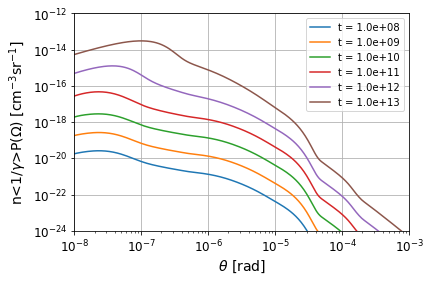

In [25]:
for i in range(t_num):
    plt.plot(Omega_x, -mc2[:, 1+i], label=f't = {t_arr[i]:.1e}')
    
plt.legend(loc = 'upper right')
plt.xlabel(r'$\theta$ [rad]', fontsize=14)
plt.ylabel('n<1/$\gamma$>P($\Omega$) [$\mathrm{cm}^{-3}\mathrm{sr}^{-1}$]', fontsize=14)
plt.xlim([1e-8, 1e-3])
plt.ylim([1e-24, 1e-12])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.savefig('coulomb_scattering.pdf', bbox_inches='tight')
plt.show()

In [26]:
np.savetxt('deriv_array_final.dat', mc2)